# Octank IIoT Data Analytics Notebook
Demonstration of [AWS IoT Analytics](https://aws.amazon.com/iot-analytics/) Notebooks, using real-time sensor data.

In [1]:
import boto3
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters

In [2]:
def parse(x):
    x = pd.to_numeric(x, downcast="float")
    return pd.Timestamp(x, unit="s")

In [3]:
%%time

client = boto3.client("iotanalytics")
dataset = "iot_data_dataset"
data_location = client.get_dataset_content(datasetName = dataset)["entries"][0]["dataURI"]
df = pd.read_csv(data_location,
                      header=0, 
                      low_memory=False, 
                      infer_datetime_format=True, 
                      date_parser=parse,
                      index_col=["ts"])

ParserError: Error tokenizing data. C error: out of memory

In [1]:
df.drop(columns="__dt")

NameError: name 'df' is not defined

In [4]:
print(df.head(5))

                                 device   humidity       temp  light  motion  \
ts                                                                             
2020-07-06 02:08:00  iot-demo-device-03  48.799999  70.700000  False   False   
2020-07-06 02:08:00  iot-demo-device-02  47.099998  80.960001   True   False   
2020-07-06 02:08:00  iot-demo-device-01  73.500000  67.460001  False   False   
2020-07-06 02:08:00  iot-demo-device-03  48.700001  70.519999  False   False   
2020-07-06 02:08:00  iot-demo-device-01  73.599998  67.460001  False   False   

                          lpg        co     smoke                     __dt  
ts                                                                          
2020-07-06 02:08:00  0.007549  0.004865  0.020122  2020-07-06 00:00:00.000  
2020-07-06 02:08:00  0.007657  0.004961  0.020428  2020-07-06 00:00:00.000  
2020-07-06 02:08:00  0.006288  0.003779  0.016552  2020-07-06 00:00:00.000  
2020-07-06 02:08:00  0.007561  0.004876  0.020155  202

In [5]:
print("Dataset Range")
print("-------------")
print("Record count: {:,}".format(df["temp"].count()))
print("Time range (min): {:%Y-%m-%d %H:%M:%S UTC}".format(df.index[-1]))
print("Time range (max): {:%Y-%m-%d %H:%M:%S UTC}".format(df.index[1]))
print("Records:\n{}".format(df.groupby("device").size()))

Dataset Range
-------------
Record count: 527,156
Time range (min): 2020-06-29 17:12:32 UTC
Time range (max): 2020-07-06 02:08:00 UTC
Records:
device
iot-demo-device-01    153644
iot-demo-device-02    150249
iot-demo-device-03    223263
dtype: int64


In [6]:
%%time

df_filtered = df.sort_values(ascending=False, by="ts").head(25000)

q_low = df_filtered["humidity"].quantile(0.01)
q_hi  = df_filtered["humidity"].quantile(0.99)
df_filtered = df_filtered[(df_filtered["humidity"] < q_hi) & 
                          (df_filtered["humidity"] > q_low)]

q_low = df_filtered["temp"].quantile(0.01)
q_hi  = df_filtered["temp"].quantile(0.99)
df_filtered = df_filtered[(df_filtered["temp"] < q_hi) & 
                          (df_filtered["temp"] > q_low)]

groups = df_filtered.groupby("device")

CPU times: user 129 ms, sys: 20.4 ms, total: 149 ms
Wall time: 75.2 ms


In [7]:
print("Dataset Range")
print("-------------")
print("Trimmed record count: {:,}".format(df_filtered["temp"].count()))
print("Time range (min): {:%Y-%m-%d %H:%M:%S UTC}".format(df_filtered.index[-1]))
print("Time range (max): {:%Y-%m-%d %H:%M:%S UTC}".format(df_filtered.index[1]))
print("Temperature (min): {:.2f}".format(df_filtered["temp"].min()))
print("Temperature (max): {:.2f}".format(df_filtered["temp"].max()))
print("Humidity (min): {:.2f}{}".format(df_filtered["humidity"].min(),"%"))
print("Humidity (max): {:.2f}{}".format(df_filtered["humidity"].max(),"%"))
print("Records:\n{}".format(groups.size()))

Dataset Range
-------------
Trimmed record count: 23,780
Time range (min): 2020-07-06 00:29:52 UTC
Time range (max): 2020-07-06 12:45:52 UTC
Temperature (min): 65.84
Temperature (max): 81.50
Humidity (min): 46.60%
Humidity (max): 74.30%
Records:
device
iot-demo-device-01     6740
iot-demo-device-02     5637
iot-demo-device-03    11403
dtype: int64


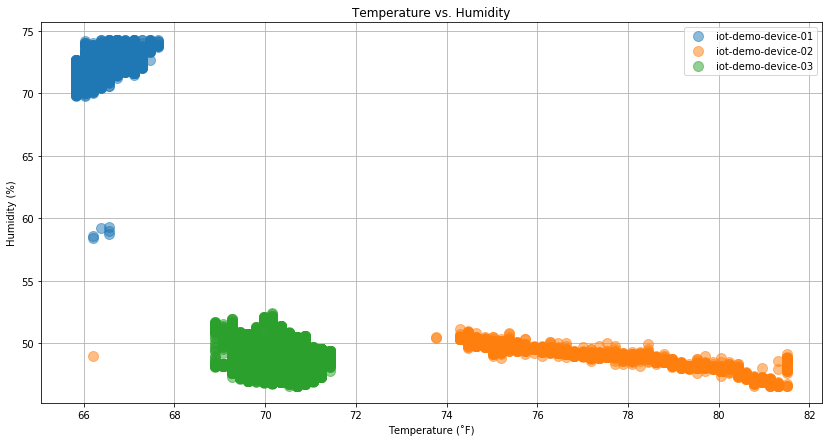

In [8]:
_, ax = plt.subplots(1, 1, figsize=(14,7))
for device, group in groups:
    ax.plot(group.temp, 
            group.humidity, 
            marker="o", 
            linestyle="", 
            alpha=.5,
            ms=10, 
            label=device)
ax.grid()
ax.margins(0.05)
ax.legend()
plt.title("Temperature vs. Humidity")
plt.xlabel("Temperature (˚F)")
plt.ylabel("Humidity (%)")
plt.show()

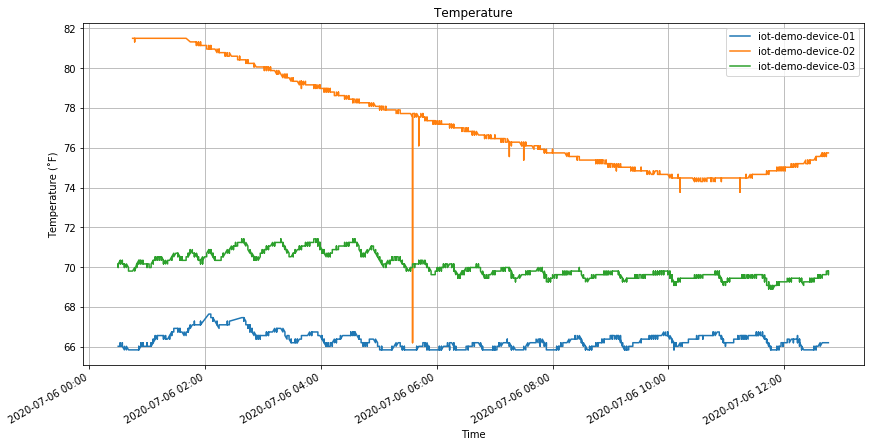

In [9]:
register_matplotlib_converters()
myFmt = DateFormatter("%Y-%m-%d %H:%M")

fig, ax = plt.subplots(1, 1, figsize=(14,7))
for device, group in groups:
    ax.plot(group.temp,
            label=device)
ax.xaxis.set_major_formatter(myFmt)
fig.autofmt_xdate()
ax.grid()
ax.margins(0.05)
ax.legend()
plt.title("Temperature")
plt.ylabel("Temperature (˚F)")
plt.xlabel("Time")
plt.show()

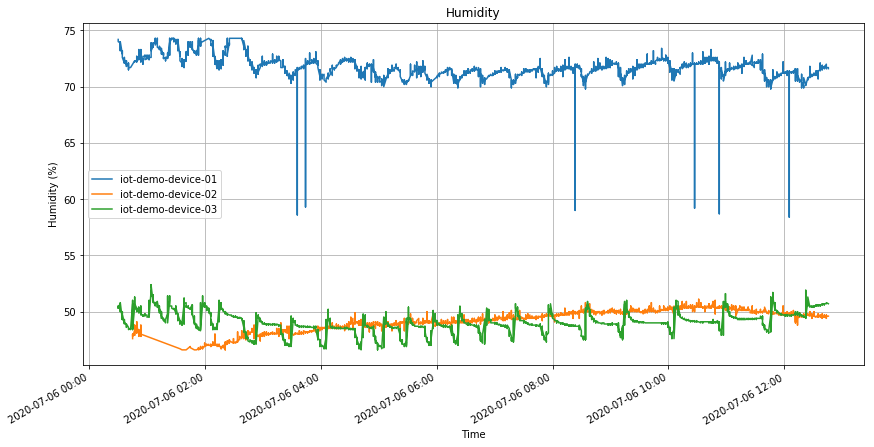

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(14,7))
for device, group in groups:
    ax.plot(group.humidity,
            label=device)
ax.xaxis.set_major_formatter(myFmt)
fig.autofmt_xdate()
ax.grid()
ax.margins(0.05)
ax.legend()
plt.title("Humidity")
plt.ylabel("Humidity (%)")
plt.xlabel("Time")
plt.show()